# Notebook 4: Autoencoder Model for Anomaly Detection

## ML-Based Drone Firmware Tampering Detection System

This notebook covers:
- Loading processed data
- Building autoencoder for anomaly detection
- Training on clean data only
- Detecting tampered firmware as anomalies
- Model evaluation
- Threshold optimization


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
np.random.seed(42)
tf.random.set_seed(42)

print("Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")


Libraries imported successfully!
TensorFlow version: 2.18.0


In [ ]:
# Load processed data
DATA_DIR = Path('../data')
X_train = pd.read_csv(DATA_DIR / 'X_train.csv').values
X_test = pd.read_csv(DATA_DIR / 'X_test.csv').values
y_train = pd.read_csv(DATA_DIR / 'y_train.csv').values.ravel()
y_test = pd.read_csv(DATA_DIR / 'y_test.csv').values.ravel()

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

# Separate clean data for training (autoencoder learns normal patterns)
X_train_clean = X_train[y_train == 1]
print(f"\nClean training samples: {X_train_clean.shape}")
print(f"Tampered training samples: {X_train[y_train == 0].shape[0]}")


Training set: (1600, 30)
Test set: (400, 30)

Clean training samples: (800, 30)
Tampered training samples: 800


In [ ]:
# Build Autoencoder model
def build_autoencoder(input_dim, encoding_dim=16):
    """
    Build autoencoder for anomaly detection
    """
    # Encoder
    input_layer = layers.Input(shape=(input_dim,))
    encoded = layers.Dense(64, activation='relu')(input_layer)
    encoded = layers.Dropout(0.2)(encoded)
    encoded = layers.Dense(32, activation='relu')(encoded)
    encoded = layers.Dropout(0.2)(encoded)
    encoded = layers.Dense(encoding_dim, activation='relu')(encoded)
    
    # Decoder
    decoded = layers.Dense(32, activation='relu')(encoded)
    decoded = layers.Dropout(0.2)(decoded)
    decoded = layers.Dense(64, activation='relu')(decoded)
    decoded = layers.Dropout(0.2)(decoded)
    decoded = layers.Dense(input_dim, activation='linear')(decoded)
    
    autoencoder = keras.Model(input_layer, decoded)
    
    autoencoder.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    
    return autoencoder

# Build model
input_dim = X_train_clean.shape[1]
encoding_dim = 16
autoencoder = build_autoencoder(input_dim, encoding_dim)

print("Autoencoder architecture:")
autoencoder.summary()


Autoencoder architecture:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 30)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           1,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 30)                  │           1,950 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,198 (35.93 KB)

 Trainable params: 9,198 (35.93 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Define callbacks
MODELS_DIR = Path('../models')
MODELS_DIR.mkdir(exist_ok=True)

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ModelCheckpoint(
        filepath=MODELS_DIR / 'autoencoder_model_best.h5',
        monitor='loss',
        save_best_only=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

print("Callbacks configured")


Callbacks configured


In [ ]:
# Train the autoencoder on clean data only
print("Training Autoencoder on clean data...")
print("=" * 50)

history = autoencoder.fit(
    X_train_clean, X_train_clean,  # Input and target are the same (reconstruction)
    batch_size=32,
    epochs=100,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

print("\nTraining completed!")


Training Autoencoder on clean data...
Epoch 1/100
11/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4846 - mae: 0.4649 
Epoch 1: loss improved from inf to 0.47710, saving model to ..\models\autoencoder_model_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - loss: 0.4778 - mae: 0.4577 - val_loss: 0.3799 - val_mae: 0.4101 - learning_rate: 0.0010
Epoch 2/100
12/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3863 - mae: 0.4141 
Epoch 2: loss improved from 0.47710 to 0.39363, saving model to ..\models\autoencoder_model_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.3856 - mae: 0.4130 - val_loss: 0.3073 - val_mae: 0.3640 - learning_rate: 0.0010
Epoch 3/100
15/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3288 - mae: 0.3838 
Epoch 3: loss improved from 0.39363 to 0.34764, saving model to ..\models\autoencoder_model_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.3332 - mae: 0.3848 - val_loss: 0.2650 - val_mae: 0.3448 - learning_rate: 0.0010
Epoch 4/100
13/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2987 - mae: 0.3741  
Epoch 4: loss improved from 0.34764 to 0.31378, saving model to ..\models\autoencoder_model_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.3019 - mae: 0.3750 - val_loss: 0.2309 - val_mae: 0.3291 - learning_rate: 0.0010
Epoch 5/100
19/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2721 - mae: 0.3611 
Epoch 5: loss improved from 0.31378 to 0.28001, saving model to ..\models\autoencoder_model_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2728 - mae: 0.3614 - val_loss: 0.1953 - val_mae: 0.3116 - learning_rate: 0.0010
Epoch 6/100
17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2466 - mae: 0.3508 
Epoch 6: loss improved from 0.28001 to 0.25119, saving model to ..\models\autoencoder_model_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2472 - mae: 0.3515 - val_loss: 0.1808 - val_mae: 0.3031 - learning_rate: 0.0010
Epoch 7/100
16/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2318 - mae: 0.3416 
Epoch 7: loss improved from 0.25119 to 0.23946, saving model to ..\models\autoencoder_model_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2331 - mae: 0.3422 - val_loss: 0.1545 - val_mae: 0.2861 - learning_rate: 0.0010
Epoch 8/100
14/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2111 - mae: 0.3295 
Epoch 8: loss improved from 0.23946 to 0.22444, saving model to ..\models\autoencoder_model_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2145 - mae: 0.3309 - val_loss: 0.1450 - val_mae: 0.2776 - learning_rate: 0.0010
Epoch 9/100
15/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1966 - mae: 0.3195 
Epoch 9: loss improved from 0.22444 to 0.20477, saving model to ..\models\autoencoder_model_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1986 - mae: 0.3204 - val_loss: 0.1312 - val_mae: 0.2646 - learning_rate: 0.0010
Epoch 10/100
 8/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1955 - mae: 0.3154 
Epoch 10: loss improved from 0.20477 to 0.20059, saving model to ..\models\autoencoder_model_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1951 - mae: 0.3150 - val_loss: 0.1257 - val_mae: 0.2606 - learning_rate: 0.0010
Epoch 11/100
16/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1803 - mae: 0.3067 
Epoch 11: loss improved from 0.20059 to 0.18950, saving model to ..\models\autoencoder_model_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1822 - mae: 0.3074 - val_loss: 0.1225 - val_mae: 0.2573 - learning_rate: 0.0010
Epoch 12/100
15/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1743 - mae: 0.3023 
Epoch 12: loss improved from 0.18950 to 0.18316, saving model to ..\models\autoencoder_model_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1763 - mae: 0.3031 - val_loss: 0.1224 - val_mae: 0.2552 - learning_rate: 0.0010
Epoch 13/100
13/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1732 - mae: 0.2996 
Epoch 13: loss improved from 0.18316 to 0.17927, saving model to ..\models\autoencoder_model_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1750 - mae: 0.3004 - val_loss: 0.1181 - val_mae: 0.2533 - learning_rate: 0.0010
Epoch 14/100
14/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1640 - mae: 0.2922 
Epoch 14: loss improved from 0.17927 to 0.17742, saving model to ..\models\autoencoder_model_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1680 - mae: 0.2936 - val_loss: 0.1165 - val_mae: 0.2519 - learning_rate: 0.0010
Epoch 15/100
13/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1645 - mae: 0.2906 
Epoch 15: loss improved from 0.17742 to 0.16829, saving model to ..\models\autoencoder_model_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1656 - mae: 0.2914 - val_loss: 0.1155 - val_mae: 0.2484 - learning_rate: 0.0010
Epoch 16/100
17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1583 - mae: 0.2856 
Epoch 16: loss improved from 0.16829 to 0.16335, saving model to ..\models\autoencoder_model_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1591 - mae: 0.2862 - val_loss: 0.1159 - val_mae: 0.2491 - learning_rate: 0.0010
Epoch 17/100
13/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1525 - mae: 0.2828 
Epoch 17: loss improved from 0.16335 to 0.16044, saving model to ..\models\autoencoder_model_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1544 - mae: 0.2834 - val_loss: 0.1103 - val_mae: 0.2432 - learning_rate: 0.0010
Epoch 18/100
15/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1538 - mae: 0.2786 
Epoch 18: loss improved from 0.16044 to 0.15620, saving model to ..\models\autoencoder_model_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1542 - mae: 0.2798 - val_loss: 0.1107 - val_mae: 0.2434 - learning_rate: 0.0010
Epoch 19/100
15/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1504 - mae: 0.2784 
Epoch 19: loss improved from 0.15620 to 0.15277, saving model to ..\models\autoencoder_model_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1507 - mae: 0.2788 - val_loss: 0.1125 - val_mae: 0.2454 - learning_rate: 0.0010
Epoch 20/100
14/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1474 - mae: 0.2743 
Epoch 20: loss improved from 0.15277 to 0.15197, saving model to ..\models\autoencoder_model_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1484 - mae: 0.2750 - val_loss: 0.1060 - val_mae: 0.2393 - learning_rate: 0.0010
Epoch 21/100
14/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1497 - mae: 0.2737 
Epoch 21: loss did not improve from 0.15197
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1512 - mae: 0.2752 - val_loss: 0.1056 - val_mae: 0.2393 - learning_rate: 0.0010
Epoch 22/100
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1510 - mae: 0.2760 
Epoch 22: loss did not improve from 0.15197
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1519 - mae: 0.2765 - val_loss: 0.1046 - val_mae: 0.2387 - learning_rate: 0.0010
Epoch 23/100
14/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1460 - mae: 0.2698 
Epoch 23: loss did not improve from 0.15197
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1470 - mae: 0.2715 - val_loss: 0.1045 - val_mae: 0.2373 - learning_rate: 0.0010
Epoch 24/100
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1443 - mae: 0.2680 
Epoch 24: loss impro

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1450 - mae: 0.2687 - val_loss: 0.1007 - val_mae: 0.2328 - learning_rate: 0.0010
Epoch 25/100
14/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1404 - mae: 0.2682 
Epoch 25: loss improved from 0.14946 to 0.14616, saving model to ..\models\autoencoder_model_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1420 - mae: 0.2692 - val_loss: 0.1103 - val_mae: 0.2411 - learning_rate: 0.0010
Epoch 26/100
15/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1406 - mae: 0.2673 
Epoch 26: loss improved from 0.14616 to 0.14604, saving model to ..\models\autoencoder_model_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1419 - mae: 0.2680 - val_loss: 0.1018 - val_mae: 0.2328 - learning_rate: 0.0010
Epoch 27/100
16/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1383 - mae: 0.2672 
Epoch 27: loss improved from 0.14604 to 0.13859, saving model to ..\models\autoencoder_model_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1382 - mae: 0.2673 - val_loss: 0.1026 - val_mae: 0.2346 - learning_rate: 0.0010
Epoch 28/100
17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1419 - mae: 0.2662 
Epoch 28: loss did not improve from 0.13859
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1427 - mae: 0.2664 - val_loss: 0.0990 - val_mae: 0.2302 - learning_rate: 0.0010
Epoch 29/100
16/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1452 - mae: 0.2657 
Epoch 29: loss did not improve from 0.13859
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1455 - mae: 0.2661 - val_loss: 0.0985 - val_mae: 0.2300 - learning_rate: 0.0010
Epoch 30/100
15/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1323 - mae: 0.2584 
Epoch 30: loss did not improve from 0.13859
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1337 - mae: 0.2593 - val_loss: 0.1018 - val_mae: 0.2325 - learning_rate: 0.0010
Epoch 31/100
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1389 - mae: 0.2617 
Epoch 31: loss did n

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1357 - mae: 0.2628 - val_loss: 0.0981 - val_mae: 0.2290 - learning_rate: 0.0010
Epoch 33/100
15/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1302 - mae: 0.2578 
Epoch 33: loss improved from 0.13704 to 0.13569, saving model to ..\models\autoencoder_model_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1316 - mae: 0.2586 - val_loss: 0.0996 - val_mae: 0.2312 - learning_rate: 0.0010
Epoch 34/100
15/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1296 - mae: 0.2576 
Epoch 34: loss did not improve from 0.13569
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1312 - mae: 0.2578 - val_loss: 0.0954 - val_mae: 0.2260 - learning_rate: 0.0010
Epoch 35/100
16/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1284 - mae: 0.2577 
Epoch 35: loss did not improve from 0.13569
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1300 - mae: 0.2583 - val_loss: 0.0989 - val_mae: 0.2297 - learning_rate: 0.0010
Epoch 36/100
14/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1311 - mae: 0.2586 
Epoch 36: loss did not improve from 0.13569
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1335 - mae: 0.2596 - val_loss: 0.0987 - val_mae: 0.2314 - learning_rate: 0.0010
Epoch 37/100
16/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1360 - mae: 0.2571 
Epoch 37: loss did n

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1308 - mae: 0.2554 - val_loss: 0.0978 - val_mae: 0.2268 - learning_rate: 0.0010
Epoch 39/100
12/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1287 - mae: 0.2553 
Epoch 39: loss did not improve from 0.13256
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1291 - mae: 0.2558 - val_loss: 0.0959 - val_mae: 0.2253 - learning_rate: 0.0010
Epoch 40/100
10/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1331 - mae: 0.2605 
Epoch 40: loss did not improve from 0.13256
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1319 - mae: 0.2592 - val_loss: 0.0999 - val_mae: 0.2306 - learning_rate: 0.0010
Epoch 41/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1308 - mae: 0.2552  
Epoch 41: loss did not improve from 0.13256
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1310 - mae: 0.2553 - val_loss: 0.0951 - val_mae: 0.2250 - learning_rate: 0.0010
Epoch 42/100
11/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1227 - mae: 0.2509 
Epoch 42: loss impr

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.1238 - mae: 0.2523 - val_loss: 0.0991 - val_mae: 0.2286 - learning_rate: 0.0010
Epoch 43/100
13/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1239 - mae: 0.2517 
Epoch 43: loss did not improve from 0.12710
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1262 - mae: 0.2531 - val_loss: 0.0954 - val_mae: 0.2251 - learning_rate: 0.0010
Epoch 44/100
11/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1204 - mae: 0.2501 
Epoch 44: loss did not improve from 0.12710
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1227 - mae: 0.2512 - val_loss: 0.0961 - val_mae: 0.2248 - learning_rate: 0.0010
Epoch 45/100
12/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1235 - mae: 0.2531 
Epoch 45: loss did not improve from 0.12710
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1245 - mae: 0.2531 - val_loss: 0.0973 - val_mae: 0.2276 - learning_rate: 0.0010
Epoch 46/100
11/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1202 - mae: 0.2480 
Epoch 46: loss impro

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1218 - mae: 0.2489 - val_loss: 0.0942 - val_mae: 0.2229 - learning_rate: 0.0010
Epoch 47/100
15/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1252 - mae: 0.2508 
Epoch 47: loss did not improve from 0.12658
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1271 - mae: 0.2521 - val_loss: 0.0948 - val_mae: 0.2253 - learning_rate: 0.0010
Epoch 48/100
16/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1246 - mae: 0.2512  
Epoch 48: loss did not improve from 0.12658
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1255 - mae: 0.2518 - val_loss: 0.0977 - val_mae: 0.2274 - learning_rate: 0.0010
Epoch 49/100
11/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1242 - mae: 0.2519  
Epoch 49: loss improved from 0.12658 to 0.12609, saving model to ..\models\autoencoder_model_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.1250 - mae: 0.2528 - val_loss: 0.0953 - val_mae: 0.2242 - learning_rate: 0.0010
Epoch 50/100
15/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1215 - mae: 0.2477 
Epoch 50: loss improved from 0.12609 to 0.12492, saving model to ..\models\autoencoder_model_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1224 - mae: 0.2483 - val_loss: 0.0936 - val_mae: 0.2233 - learning_rate: 0.0010
Epoch 51/100
15/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1219 - mae: 0.2479 
Epoch 51: loss did not improve from 0.12492
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1230 - mae: 0.2486 - val_loss: 0.0945 - val_mae: 0.2239 - learning_rate: 0.0010
Epoch 52/100
16/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1230 - mae: 0.2470 
Epoch 52: loss did not improve from 0.12492
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1236 - mae: 0.2476 - val_loss: 0.0953 - val_mae: 0.2247 - learning_rate: 0.0010
Epoch 53/100
13/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1186 - mae: 0.2448 
Epoch 53: loss improved from 0.12492 to 0.12234, saving model to ..\models\autoencoder_model_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1196 - mae: 0.2462 - val_loss: 0.0939 - val_mae: 0.2213 - learning_rate: 0.0010
Epoch 54/100
13/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1180 - mae: 0.2461 
Epoch 54: loss did not improve from 0.12234
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1190 - mae: 0.2470 - val_loss: 0.0943 - val_mae: 0.2234 - learning_rate: 0.0010
Epoch 55/100
15/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1224 - mae: 0.2482 
Epoch 55: loss did not improve from 0.12234
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1239 - mae: 0.2489 - val_loss: 0.0929 - val_mae: 0.2212 - learning_rate: 0.0010
Epoch 56/100
13/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1196 - mae: 0.2467 
Epoch 56: loss did not improve from 0.12234
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1209 - mae: 0.2475 - val_loss: 0.0939 - val_mae: 0.2227 - learning_rate: 0.0010
Epoch 57/100
13/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1215 - mae: 0.2447 
Epoch 57: loss did n

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1199 - mae: 0.2463 - val_loss: 0.0922 - val_mae: 0.2214 - learning_rate: 0.0010
Epoch 59/100
12/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1196 - mae: 0.2435 
Epoch 59: loss did not improve from 0.12119
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1207 - mae: 0.2441 - val_loss: 0.0909 - val_mae: 0.2188 - learning_rate: 0.0010
Epoch 60/100
11/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1216 - mae: 0.2456 
Epoch 60: loss did not improve from 0.12119
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1216 - mae: 0.2455 - val_loss: 0.0951 - val_mae: 0.2241 - learning_rate: 0.0010
Epoch 61/100
11/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1189 - mae: 0.2437 
Epoch 61: loss did not improve from 0.12119
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1208 - mae: 0.2449 - val_loss: 0.0928 - val_mae: 0.2200 - learning_rate: 0.0010
Epoch 62/100
13/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1127 - mae: 0.2411 
Epoch 62: loss impro

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1144 - mae: 0.2420 - val_loss: 0.0919 - val_mae: 0.2187 - learning_rate: 0.0010
Epoch 63/100
14/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1193 - mae: 0.2443 
Epoch 63: loss did not improve from 0.11808
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1202 - mae: 0.2451 - val_loss: 0.0913 - val_mae: 0.2200 - learning_rate: 0.0010
Epoch 64/100
14/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1181 - mae: 0.2431 
Epoch 64: loss did not improve from 0.11808
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1188 - mae: 0.2436 - val_loss: 0.0914 - val_mae: 0.2196 - learning_rate: 0.0010
Epoch 65/100
13/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1131 - mae: 0.2414 
Epoch 65: loss improved from 0.11808 to 0.11795, saving model to ..\models\autoencoder_model_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1144 - mae: 0.2422 - val_loss: 0.0951 - val_mae: 0.2217 - learning_rate: 0.0010
Epoch 66/100
13/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1189 - mae: 0.2433 
Epoch 66: loss did not improve from 0.11795
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1198 - mae: 0.2442 - val_loss: 0.0921 - val_mae: 0.2200 - learning_rate: 0.0010
Epoch 67/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1233 - mae: 0.2456 
Epoch 67: loss did not improve from 0.11795
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1233 - mae: 0.2457 - val_loss: 0.0985 - val_mae: 0.2244 - learning_rate: 0.0010
Epoch 68/100
14/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1252 - mae: 0.2460 
Epoch 68: loss did not improve from 0.11795
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1238 - mae: 0.2455 - val_loss: 0.0913 - val_mae: 0.2184 - learning_rate: 0.0010
Epoch 69/100
14/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1148 - mae: 0.2417 
Epoch 69: loss did n

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1163 - mae: 0.2401 - val_loss: 0.0918 - val_mae: 0.2191 - learning_rate: 5.0000e-04
Epoch 72/100
14/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1213 - mae: 0.2437  
Epoch 72: loss did not improve from 0.11682
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1202 - mae: 0.2432 - val_loss: 0.0894 - val_mae: 0.2169 - learning_rate: 5.0000e-04
Epoch 73/100
14/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1134 - mae: 0.2399 
Epoch 73: loss did not improve from 0.11682
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1158 - mae: 0.2408 - val_loss: 0.0902 - val_mae: 0.2177 - learning_rate: 5.0000e-04
Epoch 74/100
15/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1153 - mae: 0.2439 
Epoch 74: loss improved from 0.11682 to 0.11547, saving model to ..\models\autoencoder_model_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1153 - mae: 0.2438 - val_loss: 0.0900 - val_mae: 0.2174 - learning_rate: 5.0000e-04
Epoch 75/100
14/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1206 - mae: 0.2423 
Epoch 75: loss did not improve from 0.11547
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1218 - mae: 0.2424 - val_loss: 0.0924 - val_mae: 0.2200 - learning_rate: 5.0000e-04
Epoch 76/100
14/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1131 - mae: 0.2398 
Epoch 76: loss improved from 0.11547 to 0.11526, saving model to ..\models\autoencoder_model_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1130 - mae: 0.2401 - val_loss: 0.0906 - val_mae: 0.2180 - learning_rate: 5.0000e-04
Epoch 77/100
15/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1129 - mae: 0.2394 
Epoch 77: loss improved from 0.11526 to 0.11488, saving model to ..\models\autoencoder_model_best.h5


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1133 - mae: 0.2398 - val_loss: 0.0889 - val_mae: 0.2159 - learning_rate: 5.0000e-04
Epoch 78/100
14/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1154 - mae: 0.2417 
Epoch 78: loss did not improve from 0.11488
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1156 - mae: 0.2419 - val_loss: 0.0913 - val_mae: 0.2189 - learning_rate: 5.0000e-04
Epoch 79/100
15/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1127 - mae: 0.2401 
Epoch 79: loss did not improve from 0.11488
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1135 - mae: 0.2406 - val_loss: 0.0918 - val_mae: 0.2187 - learning_rate: 5.0000e-04
Epoch 80/100
16/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1174 - mae: 0.2413 
Epoch 80: loss did not improve from 0.11488
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1174 - mae: 0.2417 - val_loss: 0.0911 - val_mae: 0.2170 - learning_rate: 5.0000e-04
Epoch 81/100
17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1122 - mae: 0.2391 
Epoc

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1124 - mae: 0.2394 - val_loss: 0.0885 - val_mae: 0.2151 - learning_rate: 5.0000e-04
Epoch 82/100
11/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1230 - mae: 0.2446  
Epoch 82: loss did not improve from 0.11404
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1212 - mae: 0.2441 - val_loss: 0.0895 - val_mae: 0.2172 - learning_rate: 5.0000e-04
Epoch 83/100
13/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1109 - mae: 0.2386 
Epoch 83: loss did not improve from 0.11404
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1114 - mae: 0.2386 - val_loss: 0.0908 - val_mae: 0.2181 - learning_rate: 5.0000e-04
Epoch 84/100
14/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1160 - mae: 0.2404  
Epoch 84: loss did not improve from 0.11404
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1172 - mae: 0.2410 - val_loss: 0.0892 - val_mae: 0.2165 - learning_rate: 5.0000e-04
Epoch 85/100
12/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1088 - mae: 0.2370 
Ep

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1114 - mae: 0.2405 - val_loss: 0.0891 - val_mae: 0.2168 - learning_rate: 5.0000e-04
Epoch 87/100
17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1107 - mae: 0.2376  
Epoch 87: loss did not improve from 0.11348
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1115 - mae: 0.2383 - val_loss: 0.0889 - val_mae: 0.2166 - learning_rate: 5.0000e-04
Epoch 88/100
13/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1147 - mae: 0.2396 
Epoch 88: loss did not improve from 0.11348
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1160 - mae: 0.2404 - val_loss: 0.0913 - val_mae: 0.2181 - learning_rate: 5.0000e-04
Epoch 89/100
15/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1068 - mae: 0.2347 
Epoch 89: loss did not improve from 0.11348
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1090 - mae: 0.2358 - val_loss: 0.0922 - val_mae: 0.2177 - learning_rate: 5.0000e-04
Epoch 90/100
14/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1192 - mae: 0.2418 
Epo

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1101 - mae: 0.2384 - val_loss: 0.0888 - val_mae: 0.2157 - learning_rate: 5.0000e-04
Epoch 92/100
15/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1154 - mae: 0.2401 
Epoch 92: loss did not improve from 0.11300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1168 - mae: 0.2407 - val_loss: 0.0919 - val_mae: 0.2174 - learning_rate: 5.0000e-04
Epoch 93/100
15/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1164 - mae: 0.2410 
Epoch 93: loss did not improve from 0.11300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1174 - mae: 0.2411 - val_loss: 0.0895 - val_mae: 0.2157 - learning_rate: 5.0000e-04
Epoch 94/100
15/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1110 - mae: 0.2381 
Epoch 94: loss did not improve from 0.11300
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1118 - mae: 0.2385 - val_loss: 0.0869 - val_mae: 0.2136 - learning_rate: 5.0000e-04
Epoch 95/100
16/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1087 - mae: 0.2367 
Epoc

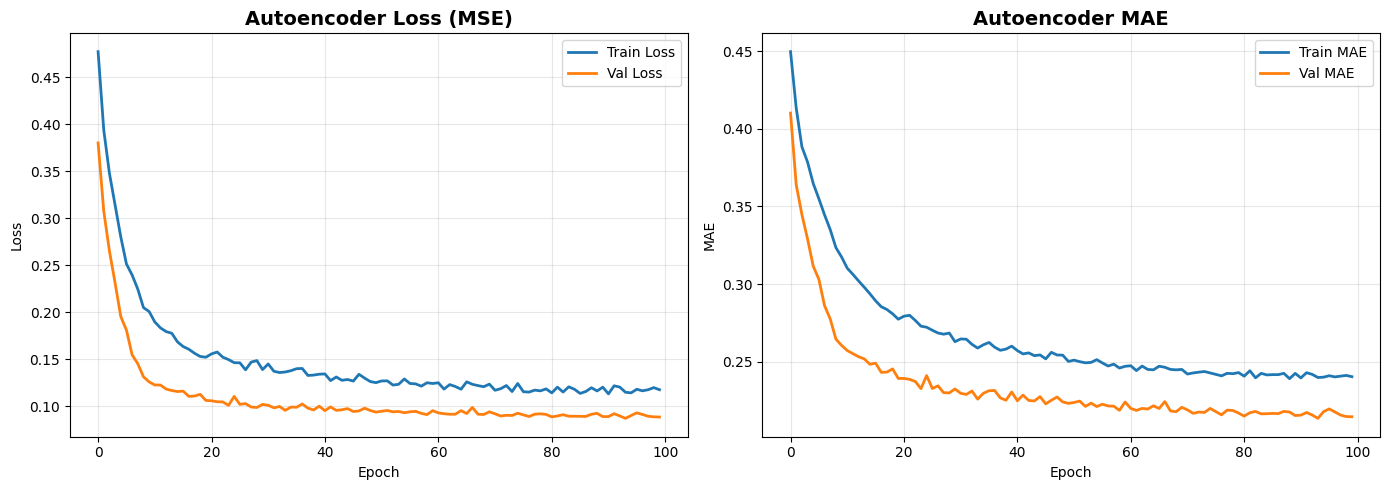

In [ ]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
axes[0].set_title('Autoencoder Loss (MSE)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# MAE
axes[1].plot(history.history['mae'], label='Train MAE', linewidth=2)
axes[1].plot(history.history['val_mae'], label='Val MAE', linewidth=2)
axes[1].set_title('Autoencoder MAE', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/autoencoder_training_history.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
# Calculate reconstruction errors
def calculate_reconstruction_error(model, data):
    """
    Calculate reconstruction error (MSE) for each sample
    """
    predictions = model.predict(data, verbose=0)
    mse = np.mean(np.power(data - predictions, 2), axis=1)
    return mse

# Calculate errors on training and test sets
train_errors = calculate_reconstruction_error(autoencoder, X_train_clean)
test_errors = calculate_reconstruction_error(autoencoder, X_test)

print(f"Training reconstruction errors - Mean: {train_errors.mean():.4f}, Std: {train_errors.std():.4f}")
print(f"Test reconstruction errors - Mean: {test_errors.mean():.4f}, Std: {test_errors.std():.4f}")

# Separate errors by label
test_errors_clean = test_errors[y_test == 1]
test_errors_tampered = test_errors[y_test == 0]

print(f"\nClean test errors - Mean: {test_errors_clean.mean():.4f}, Std: {test_errors_clean.std():.4f}")
print(f"Tampered test errors - Mean: {test_errors_tampered.mean():.4f}, Std: {test_errors_tampered.std():.4f}")


Training reconstruction errors - Mean: 0.0858, Std: 0.0224
Test reconstruction errors - Mean: 0.4205, Std: 0.4042

Clean test errors - Mean: 0.0879, Std: 0.0284
Tampered test errors - Mean: 0.7531, Std: 0.3235


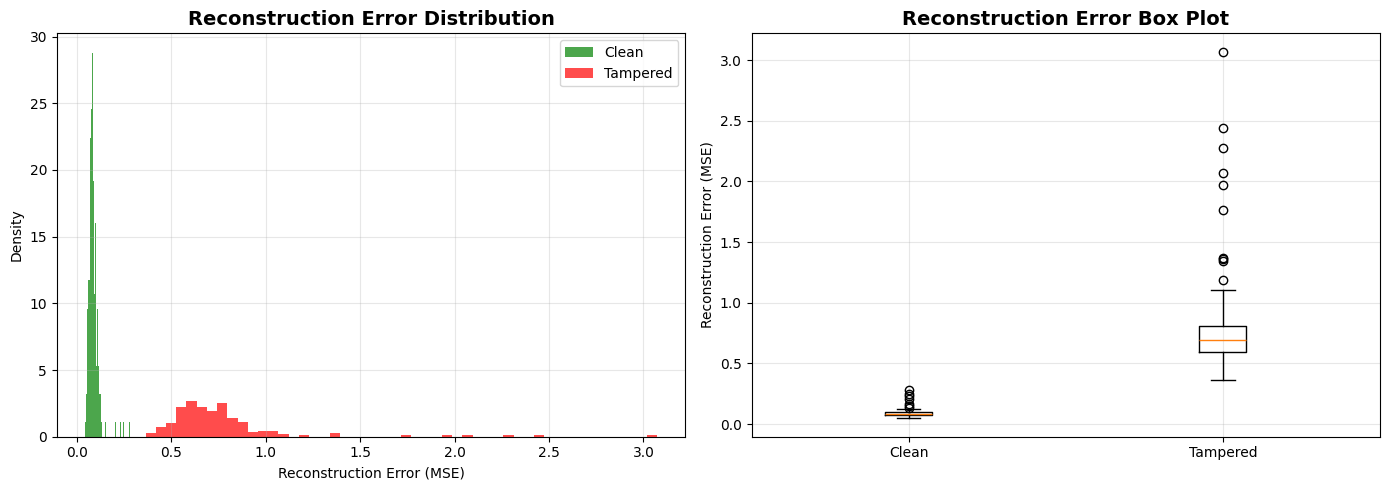

In [ ]:
# Visualize reconstruction error distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(test_errors_clean, bins=50, alpha=0.7, label='Clean', color='green', density=True)
axes[0].hist(test_errors_tampered, bins=50, alpha=0.7, label='Tampered', color='red', density=True)
axes[0].set_title('Reconstruction Error Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Reconstruction Error (MSE)')
axes[0].set_ylabel('Density')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Box plot
data_to_plot = [test_errors_clean, test_errors_tampered]
axes[1].boxplot(data_to_plot, labels=['Clean', 'Tampered'])
axes[1].set_title('Reconstruction Error Box Plot', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Reconstruction Error (MSE)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/autoencoder_error_distribution.png', dpi=300, bbox_inches='tight')
plt.show()


Best threshold: 0.0463
Best F1 score: 0.6644


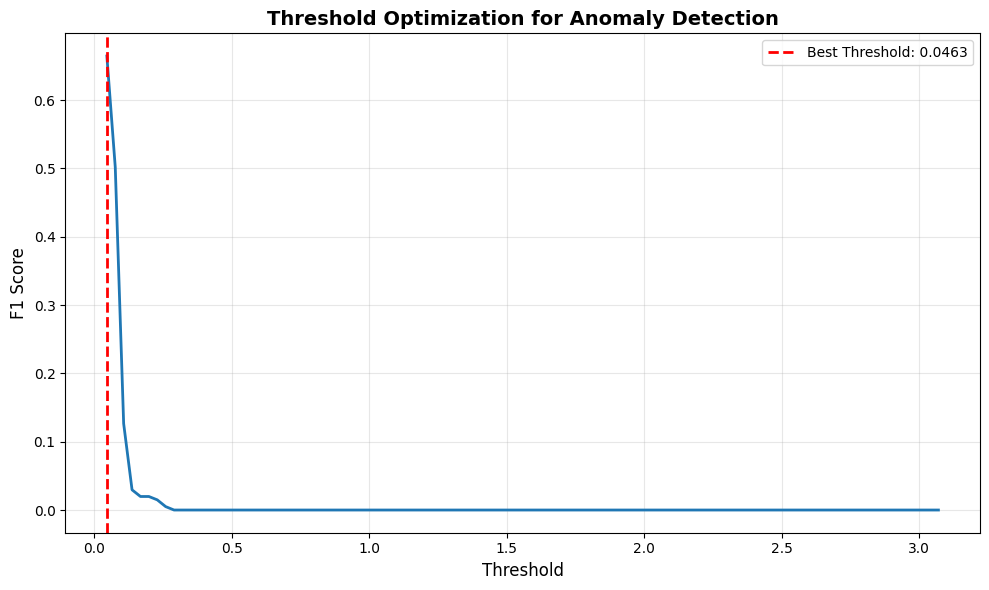

In [ ]:
# Optimize threshold
from sklearn.metrics import f1_score

# Try different thresholds
thresholds = np.linspace(test_errors.min(), test_errors.max(), 100)
f1_scores = []

for threshold in thresholds:
    y_pred = (test_errors > threshold).astype(int)
    f1 = f1_score(y_test, y_pred)
    f1_scores.append(f1)

# Find best threshold
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Best threshold: {best_threshold:.4f}")
print(f"Best F1 score: {best_f1:.4f}")

# Plot threshold optimization
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, linewidth=2)
plt.axvline(best_threshold, color='r', linestyle='--', linewidth=2, label=f'Best Threshold: {best_threshold:.4f}')
plt.xlabel('Threshold', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.title('Threshold Optimization for Anomaly Detection', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../results/autoencoder_threshold_optimization.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
# Evaluate with best threshold
y_pred = (test_errors > best_threshold).astype(int)
# Convert to probabilities (normalize errors to 0-1 range)
max_error = test_errors.max()
y_pred_proba = test_errors / max_error
y_pred_proba = np.clip(y_pred_proba, 0, 1)

print("Evaluating Autoencoder model...")
print("=" * 50)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Tampered', 'Clean']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# ROC AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC AUC Score: {roc_auc:.4f}")


Evaluating Autoencoder model...

Classification Report:
              precision    recall  f1-score   support

    Tampered       0.00      0.00      0.00       200
       Clean       0.50      0.99      0.66       200

    accuracy                           0.50       400
   macro avg       0.25      0.50      0.33       400
weighted avg       0.25      0.50      0.33       400


Confusion Matrix:
[[  0 200]
 [  1 199]]

ROC AUC Score: 0.0000


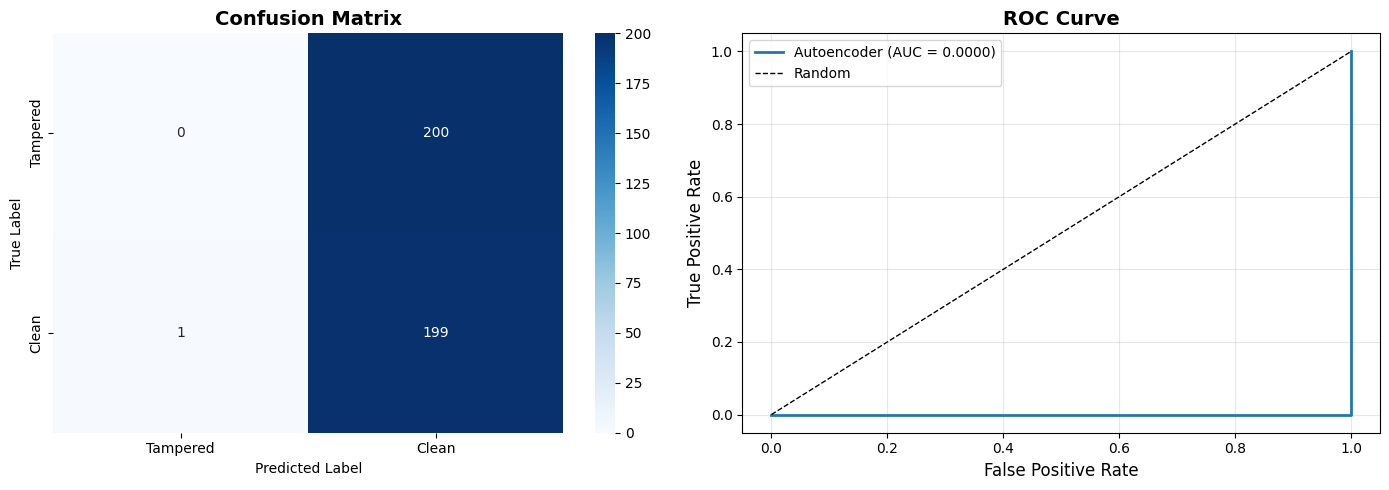

In [ ]:
# Visualize confusion matrix and ROC curve
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Tampered', 'Clean'],
            yticklabels=['Tampered', 'Clean'])
axes[0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# ROC Curve
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_proba)
axes[1].plot(fpr, tpr, linewidth=2, label=f'Autoencoder (AUC = {roc_auc:.4f})')
axes[1].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
axes[1].set_xlabel('False Positive Rate', fontsize=12)
axes[1].set_ylabel('True Positive Rate', fontsize=12)
axes[1].set_title('ROC Curve', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/autoencoder_evaluation.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
# Save model and results
RESULTS_DIR = Path('../results')
RESULTS_DIR.mkdir(exist_ok=True)

# Save model
autoencoder.save(MODELS_DIR / 'autoencoder_model_final.h5')
print(f"Model saved to {MODELS_DIR / 'autoencoder_model_final.h5'}")

# Save threshold
import pickle
with open(MODELS_DIR / 'autoencoder_threshold.pkl', 'wb') as f:
    pickle.dump({'threshold': best_threshold, 'max_error': max_error}, f)
print(f"Threshold saved to {MODELS_DIR / 'autoencoder_threshold.pkl'}")

# Save predictions and probabilities
results_df = pd.DataFrame({
    'y_true': y_test,
    'y_pred': y_pred,
    'y_pred_proba': y_pred_proba,
    'reconstruction_error': test_errors
})
results_df.to_csv(RESULTS_DIR / 'autoencoder_predictions.csv', index=False)
print(f"Predictions saved to {RESULTS_DIR / 'autoencoder_predictions.csv'}")

print("\nAutoencoder model training and evaluation completed!")


Model saved to ..\models\autoencoder_model_final.h5
Threshold saved to ..\models\autoencoder_threshold.pkl
Predictions saved to ..\results\autoencoder_predictions.csv

Autoencoder model training and evaluation completed!
